In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
data = pd.read_csv('../data/processed_data.csv')
data['date'] = pd.to_datetime(data['date'])
# data.set_index('date', inplace=True)
data.head()

,date,wm_yr_wk,weekday,wday,month,year,date_id,CASHBACK_STORE_1,CASHBACK_STORE_2,CASHBACK_STORE_3,item_id,store_id,cnt,sell_price
0,2011-01-29,11101,Saturday,1,1,2011,1,0,0,0,STORE_2_085,STORE_2,3,1.00
1,2011-01-29,11101,Saturday,1,1,2011,1,0,0,0,STORE_2_043,STORE_2,6,2.88
2,2011-01-29,11101,Saturday,1,1,2011,1,0,0,0,STORE_2_054,STORE_2,6,2.28
3,2011-01-29,11101,Saturday,1,1,2011,1,0,0,0,STORE_2_325,STORE_2,0,NaN
4,2011-01-29,11101,Saturday,1,1,2011,1,0,0,0,STORE_2_090,STORE_2,108,1.25


In [4]:
store_id = 'STORE_2'
art = '_085'
art085=data[(data.item_id==store_id + art) & (data.store_id==store_id)]
art085.set_index('date', inplace=True)

In [21]:
num_days = 90
train = art085.iloc[:-num_days]
test = art085.iloc[-num_days:]

In [22]:
import pmdarima as pm

# Автоматический подбор параметров SARIMA
smodel = pm.auto_arima(train['cnt'], 
                       seasonal=True, m=7, 
                       stepwise=True, suppress_warnings=True,
                       trace=True)

# Обучение модели SARIMA с подобранными параметрами
sarima_fit = smodel.fit(train['cnt'])

# Предсказание на тестовой выборке
forecast = sarima_fit.predict(n_periods=len(test))


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=3.55 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=10078.517, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=9748.654, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=9421.258, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=10076.517, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=9420.426, Time=0.11 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=9421.185, Time=0.22 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=9376.722, Time=0.19 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=9375.284, Time=0.51 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=9376.321, Time=1.07 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=9375.457, Time=0.73 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=9378.337, Time=1.19 sec
 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=9371

MAE: 4.101002220586246
RMSE: 28.038100549202106


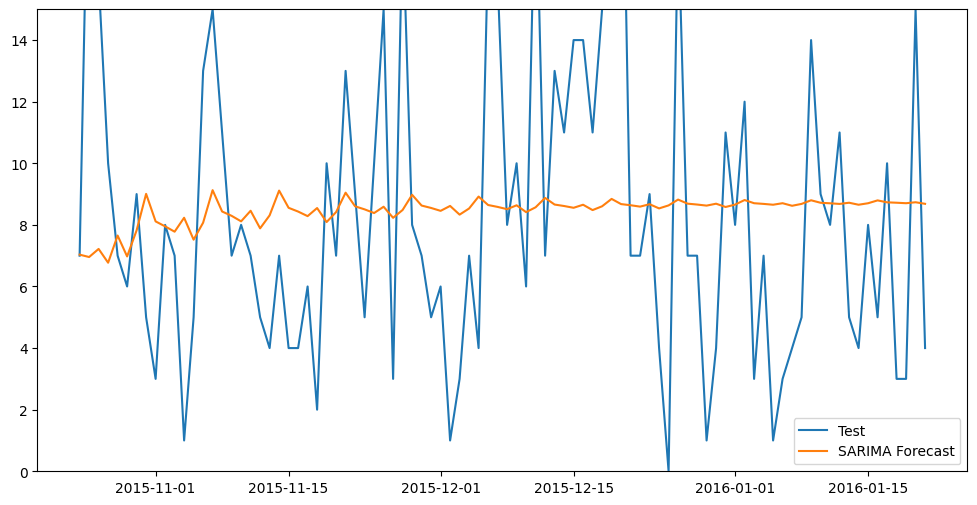

In [24]:
mae = mean_absolute_error(test.cnt, forecast)
print(f'MAE: {mae}')
rmse = mean_squared_error(test.cnt, forecast)
print(f'RMSE: {rmse}')
# Построение графика
plt.figure(figsize=(12, 6))
# plt.plot(train.index, train['cnt'], label='Train')
plt.plot(test.index, test['cnt'], label='Test')
plt.plot(test.index, forecast, label='SARIMA Forecast')
plt.ylim(0, 15)
plt.legend()
plt.show()


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error
from sktime.forecasting.base import ForecastingHorizon

df = art085
y_train, y_test = temporal_train_test_split(art085['cnt'], test_size=30)

# Создание горизонта предсказания
fh = ForecastingHorizon(y_test.index, is_relative=False)

# Определение и обучение модели auto_arima
forecaster = AutoARIMA(sp=7, seasonal=True, suppress_warnings=True)
forecaster.fit(y_train)

# Предсказание
y_pred = forecaster.predict(fh)


In [11]:
forecaster.get_fitted_params()

{'intercept': 1.7865179325134287e-05,
 'ar.L1': 1.052828288772063,
 'ar.L2': -0.1268296177813983,
 'ma.L1': -1.7791510342120922,
 'ma.L2': 0.7836579903369927,
 'ar.S.L7': 0.8969598618035953,
 'ar.S.L14': 0.012641954757480435,
 'ma.S.L7': -0.8825828948524563,
 'sigma2': 14.338534080523948,
 'order': (2, 1, 2),
 'seasonal_order': (2, 0, 1, 7),
 'aic': 9746.609699447063,
 'aicc': 9746.710936792395,
 'bic': 9796.009376048663,
 'hqic': 9764.851181009808}

MAE: 5.323716778779393
RMSE: 37.45541642574981


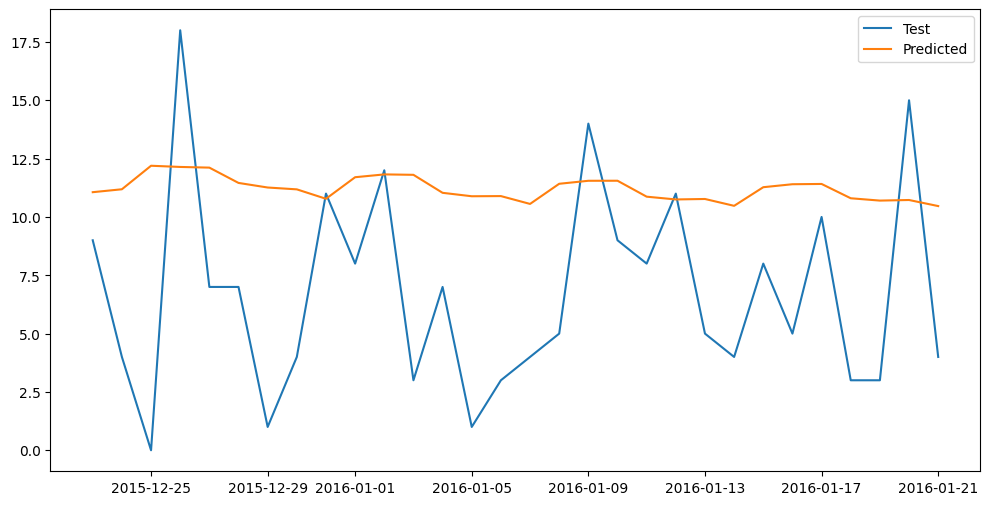

In [15]:
# Оценка качества модели
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')
rmse = mean_squared_error(y_test, y_pred)
print(f'RMSE: {rmse}')

# Построение графика
plt.figure(figsize=(12, 6))
# plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

In [26]:
df = art085.copy()
print(len(df))
df['cnt_diff'] = df['cnt'].diff().dropna()

y_train, y_test = temporal_train_test_split(df['cnt_diff'].dropna(), test_size=90)

fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = AutoARIMA(sp=7, seasonal=True, suppress_warnings=True)
forecaster.fit(y_train)

y_pred_diff = forecaster.predict(fh)

last_train_value = df['cnt'].iloc[-len(y_test)-1]
y_pred = y_pred_diff.cumsum() + last_train_value

mae = mean_absolute_error(y_test.cumsum() + last_train_value, y_pred)
print(f'RMSE: {mae}')
rmse = mean_squared_error(y_test.cumsum() + last_train_value, y_pred)
print(f'RMSE: {rmse}')

1819
RMSE: 4.116886409061304
RMSE: 28.3923209144427


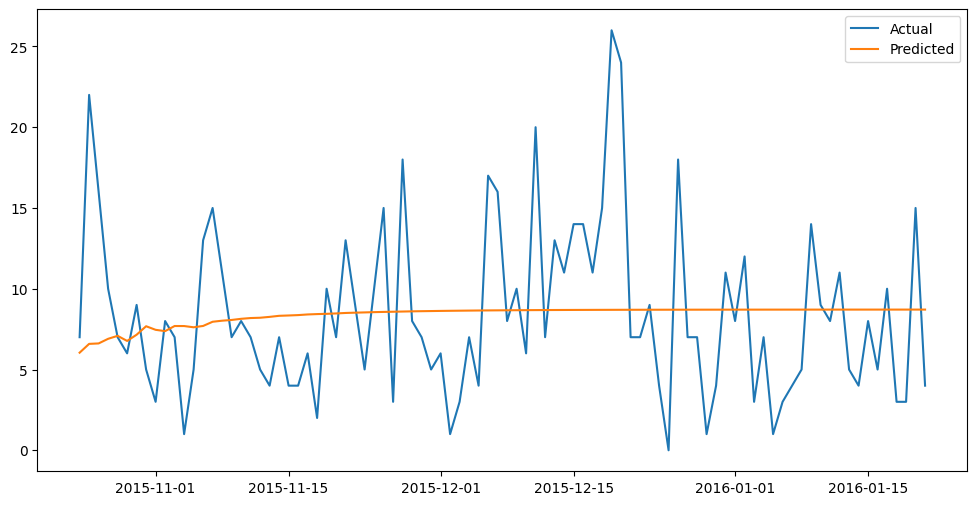

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.cumsum() + last_train_value, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()